In [29]:
import numpy as np
import skimage.transform
import scipy as sp
import scipy.ndimage
import matplotlib.pyplot as plt
import os
import nibabel as nib
from scipy.fftpack import fft, fftshift, ifft

In [30]:
# Load Chest_ct.nii using nibabel

# source: http://nipy.org/nibabel/gettingstarted.html
script_path = os.path.dirname(os.path.realpath("__file__"))
# "__file__" doesn't return the directory where file is located, but just return the current working directory (where python is called).).
# __file__ on the other hand does return the directory where the file is located, but doesn't work in interactive mode
print(f"PATH:\n{script_path}")
example_filename = os.path.join(script_path, 'Chest_ct.nii')
img = nib.load(example_filename)

# To save a .nii file:
# my_slice = img.slicer[35]
# my_slice.to_filename(os.path.join(script_path, 'slice.nii'))

# transform nibabel image into numpy array
print(f"Type of img: {type(img)}")
print(f"Shape of img: {img.shape}")  # (512, 512, 76) - 76 slices of 2D pictures
np_img = img.get_fdata()
print(f"Type of np_img: {type(np_img)}")
print(f"Shape of np_img: {np_img.shape}")

PATH:
/Users/basilerommes/Desktop/Master_UCPH/Year_2/Block_1/MIA/ass1
Type of img: <class 'nibabel.nifti1.Nifti1Image'>
Shape of img: (512, 512, 76)
Type of np_img: <class 'numpy.ndarray'>
Shape of np_img: (512, 512, 76)


In [32]:
# # we project via the y axis, onto the (x,z) plane i.e. the coronal plane
# # anatomical to cartesian plane conversion:
# # sagital = (y,z) = (1,2)
# # coronal = (x,z) = (0,2)
# # transversal = (x,y) = (0,1)

# coronal example
# plt.figure(100)
# plt.imshow(np_img[:, 256, :], aspect='auto', cmap='gray')
# plt.show()
projs = []
fig=plt.figure(figsize=(100,100))
rows = 4
columns = 3
for i in range(12):
    theta = i*30
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title(f"{theta} degrees", fontsize=130)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.tick_params(labelbottom=False)
    plt.tight_layout()
    # does spline interpolation
    rot_img = skimage.transform.rotate(np_img, angle=theta).astype('float64')  # axes=(1, 1, 0) would be logical but it is (1, 0)
    # make a projection onto the coronal (frontal) plane
    proj = rot_img.sum(axis=1)
    projs.append(proj)
    plt.imshow(proj, aspect='auto', cmap='gray')

plt.savefig(f"pictures/skimage_projections.pdf")
#plt.figure(0)

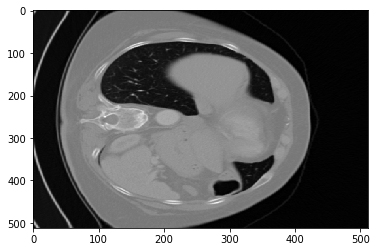

In [33]:
# discuss: look up aspect = 'auto'
slice25 = np_img[:, :, 24]
slice25.shape
plt.imshow(slice25, aspect='auto', cmap='gray')
plt.savefig(f"pictures/slice25.pdf")

(724, 180)

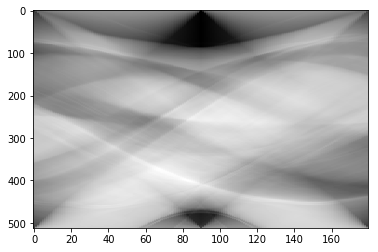

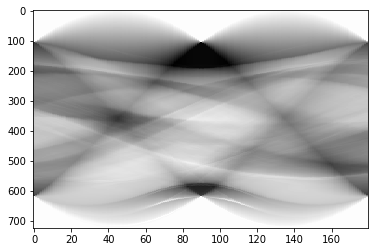

In [34]:
# inspired through: https://gist.github.com/fubel/ad01878c5a08a57be9b8b80605ad1247

# rotations without resize and padding, resulting in lost data at both ends of the projections
def discrete_radon_transform(image, steps):
    sinogram = np.zeros((len(image), steps), dtype='float64') ## image used to be np_img
    for s in range(steps):
        rot_img = skimage.transform.rotate(image, angle=s).astype('float64')  # axes=(1, 1, 0) would be logical but it is (1, 0)
        #rotation = misc.imrotate(image, -s*180/steps).astype('float64')
        sinogram[:, s] = np.sum(rot_img, axis=1)
    return sinogram

# smart rotations conserving data
def discrete_radon_transform2(image, steps):
    imgLen = image.shape[0] #len(imgage) # gives shape[0]
    # the diagonal of the original image is the width of the image rotated by 90 degree. This is the biggest our rotImg can ever get
    diagLen = int(np.sqrt(len(np_img)**2+len(np_img)**2))
    sinogram = np.zeros((diagLen, steps), dtype='float64')
    for s in range(steps):
        rot_img = skimage.transform.rotate(image, angle=s, resize=True).astype('float64')  # axes=(1, 1, 0) would be logical but it is (1, 0)
        #print(f"sinogram {sinogram.shape}")
        #print(f"rot_img {rot_img.shape}")
        rotImgLen = rot_img.shape[0]
        #padding, setps = # of rotations
        #rotation = misc.imrotate(image, -s*180/steps).astype('float64')
        # number of zeroes you are padding left and padding right have to add up to (imgLen - rotImgLen)
        # the padding to the left is at the same time the padding to the top and right is also bottom
        #print(diagLen)
        #print(rotImgLen)
        pad_l = int(np.ceil((diagLen - rotImgLen)/2))
        pad_r = int(np.floor((diagLen - rotImgLen)/2))
        #print(pad_l, pad_r)
        padded_rot = np.pad(rot_img, ((pad_l,pad_r), (pad_l,pad_r)), mode='constant', constant_values=((0,0),(0,0)))
        #print(padded_rot.shape)
        proj = np.sum(padded_rot, axis=1)
        sinogram[:, s] = proj
    return sinogram

plt.figure(1)
sinogram1 = discrete_radon_transform(slice25, 180)
plt.imshow(sinogram1, aspect="auto", cmap="gray")

plt.figure(2)
sinogram2 = discrete_radon_transform2(slice25, 180)
plt.imshow(sinogram2, aspect="auto", cmap="gray")
plt.savefig("pictures/sinogram.pdf")
sinogram2.shape

# check through reference implementation
#skimage.transform.radon(image, theta=1, circle=True)
#skimage.transform.radon(image, theta=1, circle=False)

# rot_img = sp.ndimage.interpolation.rotate(img, angle=30, axes=(1,1,0))
#
# print(rot_img.shape)
#
# rot_img.to_filename(os.path.join(script_path, 'slice.nii'))

# write what interpolation method you are using when rotating!!

# check your results with a reference implementation!

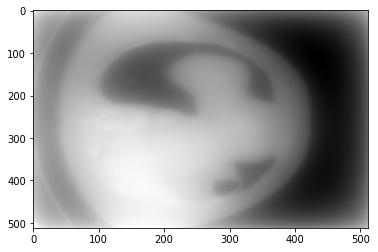

In [35]:
def my_backproject(sinogram, angles):
    imageLen = sinogram.shape[0]

    #print(sinogram.shape)
    #assert(imageLen==512)
    #assert(len(angles)==180)
    projMatrix = np.zeros((imageLen, imageLen))
    for i, theta in enumerate(angles):
        # initialize empty 
        proj = sinogram[:, i]
        #rot_projection = skimage.transform.rotate(proj, angle=-theta).astype('float64')
        #
        zeroMat = np.zeros((imageLen, imageLen))
        #print(int(np.round(imageLen/2)))
        #print(zeroMat.shape, proj.shape)
        # this puts the vector in the middle of the matrix, but we want to copy it instead
        #zeroMat[:, int(np.round(imageLen/2))] = proj
        #matrified = zeroMat
        
        #np.repeat(rot_projection, (imageLen, 1))
        # Ndarray 'matrix-vector' addition copies the 'row vector' vertically so they have the same dimensions, and then adds all entries pairwise
        matrified = zeroMat + proj
        
        # because we needed to repeat the vector horizontally, but ndarrays are by default row vectors, we have to transpose proj into column vectors (or transpose 'matrified', it doesn't matter)
        matrifiedT = matrified.T
        
        rotProj = skimage.transform.rotate(matrifiedT, angle=-theta).astype('float64')
        projMatrix += rotProj
        # axes=(1, 1, 0) would be logical but it is (1, 0) 
    # crop to get back initial dimensions
    border_l = int(np.ceil((imageLen-512)/2))
    border_r = int(np.floor((imageLen-512)/2))
    projMatrix = projMatrix[border_l:imageLen-border_r, border_l:imageLen-border_r]
    return projMatrix

reconMatrix = my_backproject(sinogram2, np.arange(180))
plt.imshow(reconMatrix, cmap='gray', aspect='auto')
plt.savefig("pictures/recon_img.pdf")
plt.show()
plt.close()

In [36]:
def normalize(M):
    norm = np.linalg.norm(M)
    if norm == 0: 
       return M
    return M / norm

def ssd(X, Y):
    """returns the sum of standard deviations"""
    assert(X.size == Y.size)
    N = X.size
    return np.sum((normalize(X) - normalize(Y))**2)/N

def ssd2(X, Y):
    """ Normalize input 2D arrays via min-max normalization, then on the normalized arrays,
    compute a sum of squared differences. Divide by the number of pixels N to get a normalized value."""
    assert(X.shape == Y.shape)
    N = X.size
    X_shift = (X-np.min(X))
    X_normalized = X_shift/np.max(X_shift)
    Y_shift = (Y-np.min(Y))
    Y_normalized = X_shift/np.max(Y-np.min(Y))
    return np.sum((X_normalized-Y_normalized)**2)/N
print(ssd(slice25, reconMatrix))
print(ssd2(slice25, reconMatrix))

def sd(X, Y):
    return np.sum(X - Y)

1.6929682279228743e-06
0.14906192654038725


In [41]:
#plt.imshow(filtered_sino, cmap='gray', aspect='auto')
#plt.show()
#ssd(sinogram, filtered_sino)

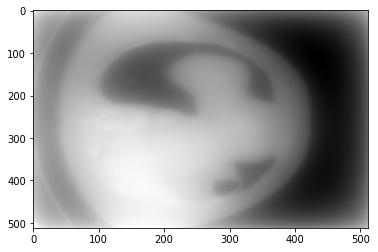

1.6929682279228743e-06

In [44]:
filtered_sino = discrete_radon_transform2(slice25, 180)
fbp = my_backproject(filtered_sino, range(180))
plt.imshow(fbp, cmap='gray', aspect='auto')
plt.show()
ssd(slice25, fbp)

In [45]:
def arange2(start, stop=None, step=1):
    """#Modified version of numpy.arange which corrects error associated with non-integer step size"""
    if stop == None:
        a = np.arange(start)
    else: 
        a = np.arange(start, stop, step)
        if a[-1] > stop-step:   
            a = np.delete(a, -1)
    return a

def ramp(x):
    return abs(x)

def my_projFilter(sino):
    projLen, numAngles = sino.shape
    shifted_sino = fftshift(sino) # shift the sinogram
    filtSino = np.zeros((projLen, numAngles)) # initialize empty matrix to write the filtered sinogram in
    step = 2*np.pi/projLen
    
    # make a range of 
    w = arange2(-np.pi, np.pi, step)
    if len(w) < projLen:
        # w[-1]+step add another step to the last element
        w = np.concatenate([w, [w[-1]+step]]) #depending on image size, it might be that len(w) =  
#projLen - 1. Another element is added to w in this case
        print(w[-1]) # see the added element. it should be pi
        print(np.pi-step + step)
    
    # apply ramp filter to w
    rampfilter = ramp(w)
    # shift it because????
    shifted_rampfilter = fftshift(rampfilter)
    for i in range(numAngles):
        
        projfft = fft(shifted_sino[:,i]) # fourrier-transform the projections
        
        # apply your choice of high-pass filter to the projections in fourrier-space
        # I went with the straight-forward Ram-Lak/ramp filter, which is the absolute value function
        # it's not good at dealing with noise, however it does get rid of blur and centered density effect
        filtProj = projfft*shifted_rampfilter
        # we are only interested in the real part of the complex fourrier result
        filtSino[:,i] = np.real(ifft(filtProj))
    return filtSino

In [ ]:
filtered_sino = my_projFilter(sinogram2)
plt.imshow(filtered_sino, cmap='gray', aspect='auto')
plt.show()

#plt.imshow(projFilter(sinogram2), cmap='gray', aspect='auto')
#plt.show()
#ssd(sinogram1, filtered_sino)

In [ ]:
from matplotlib import cm
bp = my_backproject(sinogram2, range(180))
fbp = my_backproject(filtered_sino, range(180))
#foreign_f_bp = my_backproject(projFilter(sinogram2), range(180))
plt.imshow(slice25, cmap='gray', aspect='auto')
plt.show()
plt.imshow(bp, cmap='gray', aspect='auto')
plt.show()
plt.imshow(fbp, cmap='gray', aspect='auto')
plt.show()
#plt.imshow(foreign_f_bp, cmap='gray', aspect='auto')
#plt.show()
print(ssd2(slice25, bp))
print(ssd2(slice25, fbp))
#print(ssd2(slice25, foreign_f_bp))